In [1]:
from pathlib import Path
import sys
import os
sys.path.append(os.path.abspath("..")) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import cohen_kappa_score
import re

from scripts.get_paths import get_path

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import warnings
warnings.filterwarnings("ignore")

In [2]:
paths = get_path()
df = pd.read_csv(paths.features_2 / "extracted_features.csv", index_col=False)
df_NT = df[df['NT']==1]

### Gaze: Example of frame-wise off-screen gaze deviation for various threshold values

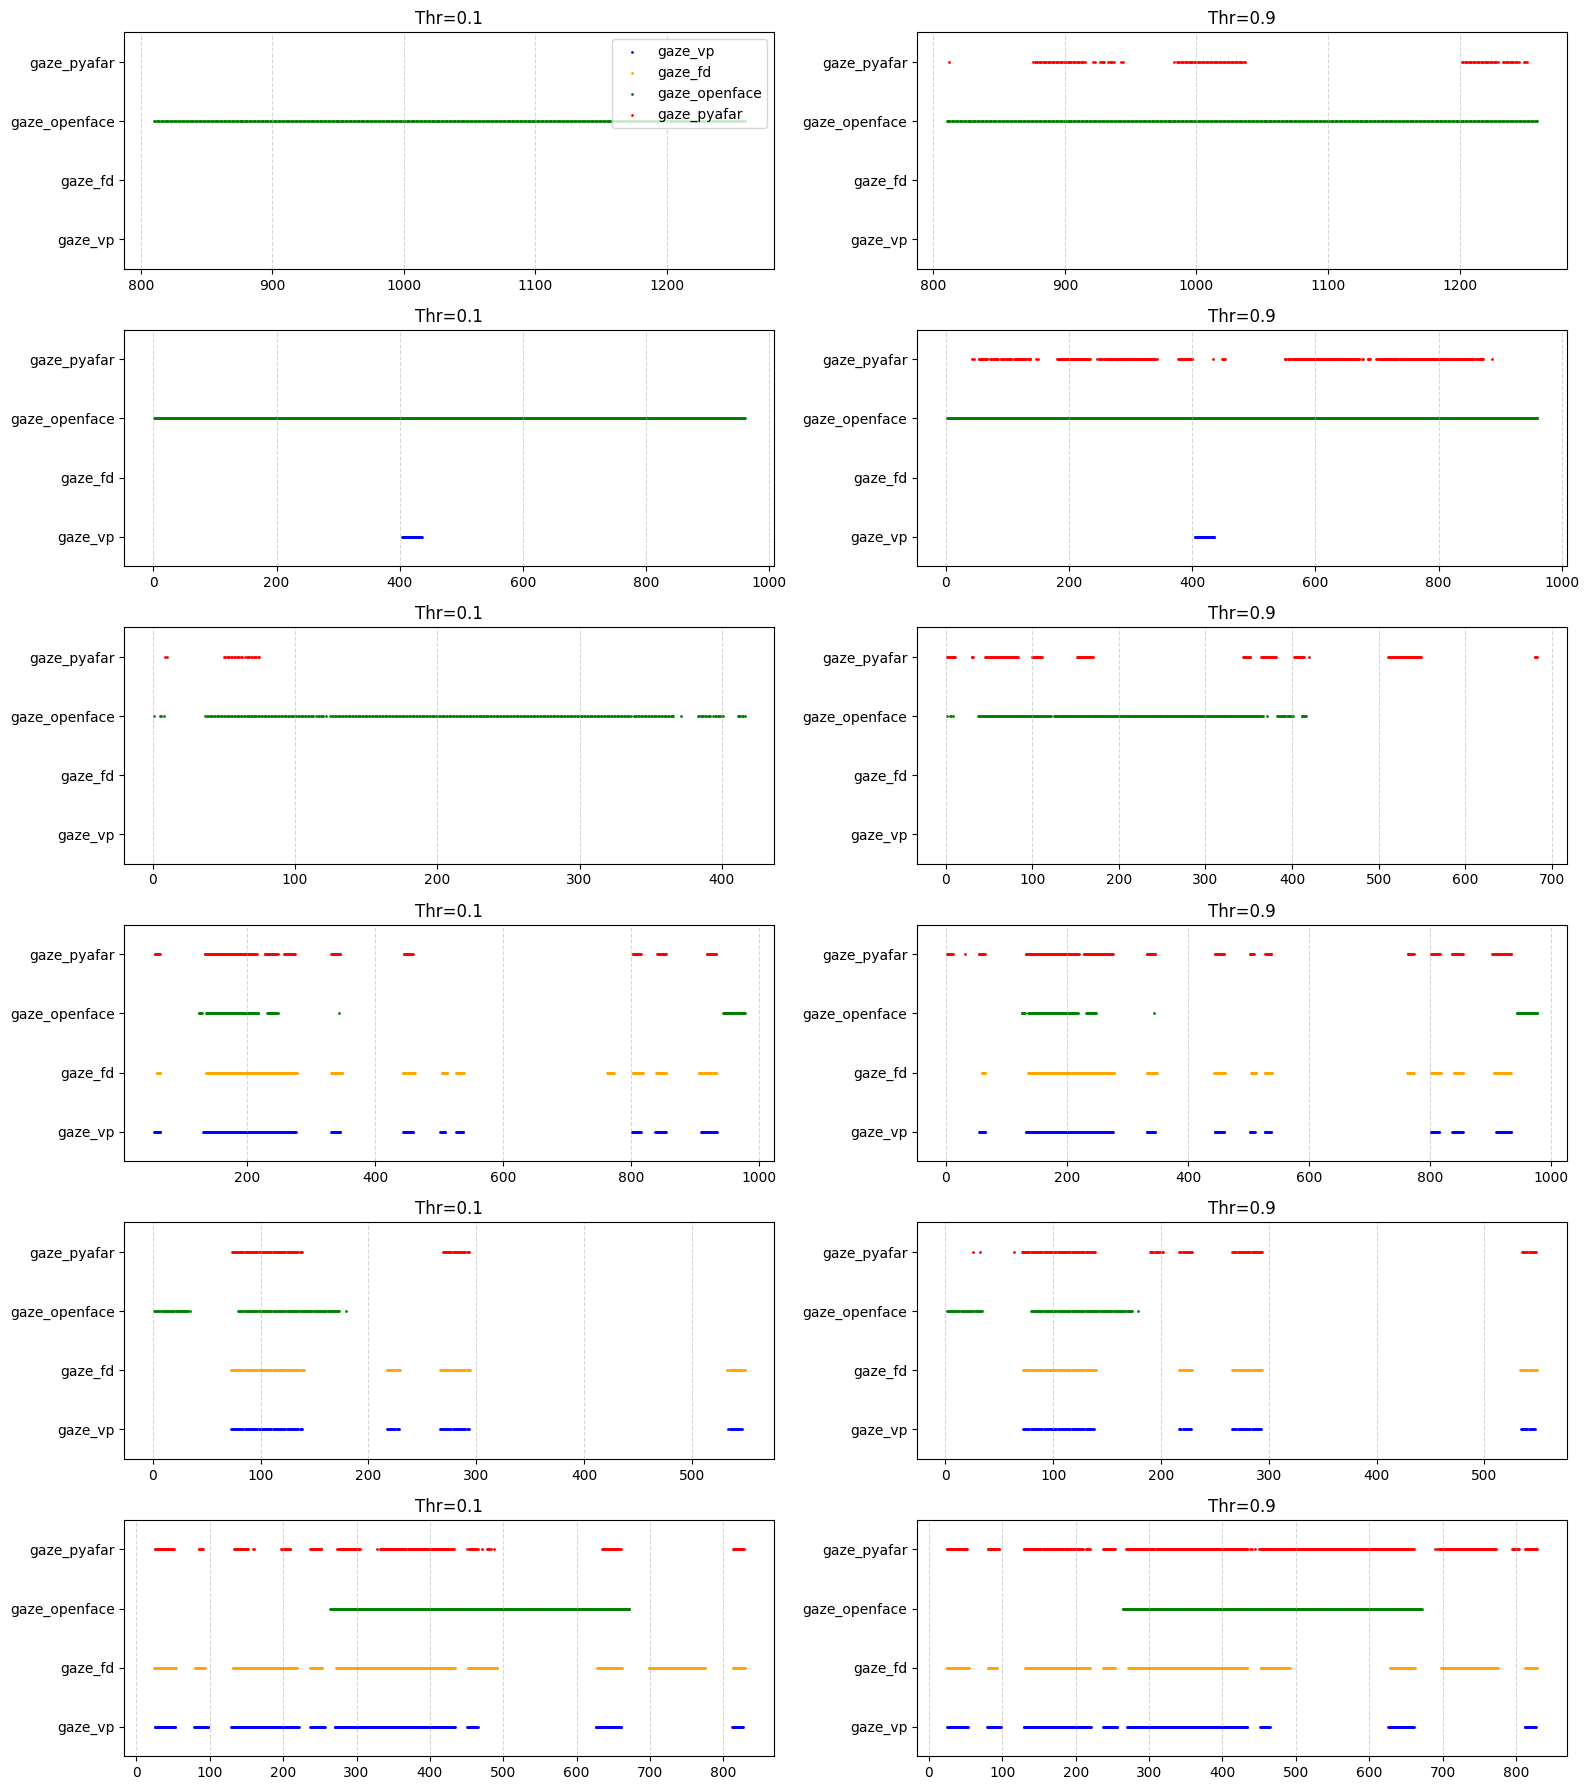

In [3]:
# Participants and clips
participant_ids = df_NT['participant_id'].unique()[0:1]  # select participants
clip_ids = sorted(df_NT['clip'].unique())              
thresholds = [0.1, 0.9]

# Measures (both gaze_openface & gaze_pyafar with FD and VP)
measures = ['gaze_vp', 'gaze_fd', 'gaze_openface', 'gaze_pyafar']
measure_display_names = ['annotator 1', 'annotator 2', 'OpenFace', 'PyAFAR']
colors = ['blue', 'orange', 'green', 'red']

# Grid dimensions
n_rows = len(participant_ids) * len(clip_ids)
n_cols = len(thresholds)

plt.figure(figsize=(8 * n_cols, 3 * n_rows))
plot_num = 1

for participant_id in participant_ids:
    for clip_id in clip_ids:  # now ordered ascending
        df_sub = df_NT[(df_NT['participant_id'] == participant_id) &
                        (df_NT['clip'] == clip_id)]
        if df_sub.empty:
            continue

        for threshold in thresholds:
            # Compute gaze_occ and gaze_dev_occ
            df_sub['gaze_pyafar'] = 1 - (df_sub['gaze_pyafar_pre'] >= threshold).astype(int) # 

            ax = plt.subplot(n_rows, n_cols, plot_num)
            for i, (measure, color) in enumerate(zip(measures, colors)):
                frames = df_sub['frame'][df_sub[measure] == 1]
                values = [i + 1] * len(frames)
                ax.scatter(frames, values, color=color, s=1, label=measure if plot_num == 1 else "")

            ax.set_yticks(range(1, len(measures) + 1))
            ax.set_yticklabels(measure_display_names) 
            ax.set_yticklabels(measures)
            ax.set_ylim(0.5, len(measures) + 0.5)
            ax.set_title(f'Thr={threshold}')
            ax.grid(axis='x', linestyle='--', alpha=0.5)

            if plot_num == 1:
                ax.legend(loc='upper right')

            plot_num += 1

plt.tight_layout()
plt.show()


### Gaze: agreement plots for different threshold values

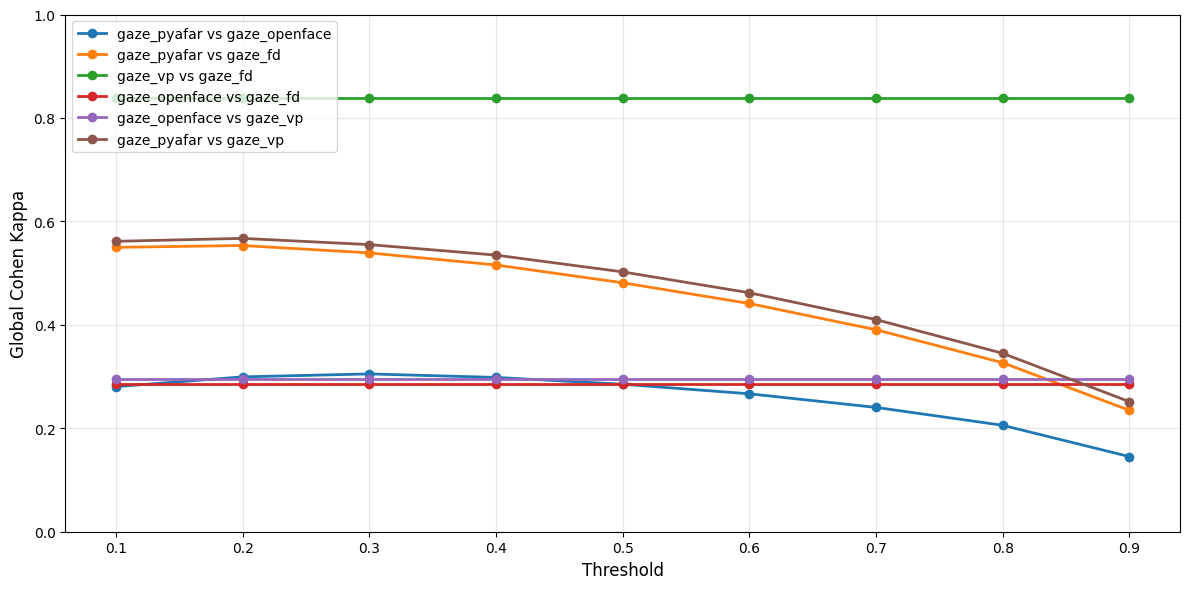

In [4]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

# Define the annotator pairs (you can add more)
annotator_compare = [
    ['gaze_pyafar', 'gaze_fd'], 
    ['gaze_vp', 'gaze_fd'], 
    ['gaze_pyafar', 'gaze_vp'],
    ['gaze_openface', 'gaze_fd'],  
    ['gaze_openface', 'gaze_vp'],
    ['gaze_pyafar', 'gaze_openface'],
    # Add more pairs if needed
]

# Thresholds to test
thresholds = np.arange(0.1, 1.0, 0.1)

# Store results
global_cohen_kappa = []

for thr in thresholds:
    # Compute binary gaze_dev_occ for this threshold
    df_NT['gaze_pyafar'] = 1 - (df_NT['gaze_pyafar_pre'] > thr).astype(int)

    for i, (annotator_1, annotator_2) in enumerate(annotator_compare):
        # Filter valid rows
        valid_rows = df_NT[[annotator_1, annotator_2]].dropna()

        # Binarize
        annotator1_binary = (valid_rows[annotator_1] != 0).astype(int)
        annotator2_binary = (valid_rows[annotator_2] != 0).astype(int)

        # Compute Cohen's kappa
        score = cohen_kappa_score(annotator1_binary, annotator2_binary)
        global_cohen_kappa.append([thr, f'{annotator_1} vs {annotator_2}', score])

# Plotting
plt.figure(figsize=(12, 6))
for annotator_pair in set([label for _, label, _ in global_cohen_kappa]):
    x = [thr for thr, label, _ in global_cohen_kappa if label == annotator_pair]
    y = [score for thr, label, score in global_cohen_kappa if label == annotator_pair]
    plt.plot(x, y, marker='o', label=annotator_pair, linewidth=2, markersize=6)

plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Global Cohen Kappa', fontsize=12)
#plt.title('Gaze Agreement vs Threshold for Different Comparisons', fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(thresholds, [f'{t:.1f}' for t in thresholds])
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


### Smile: Example of frame-wise smile for various threshold values

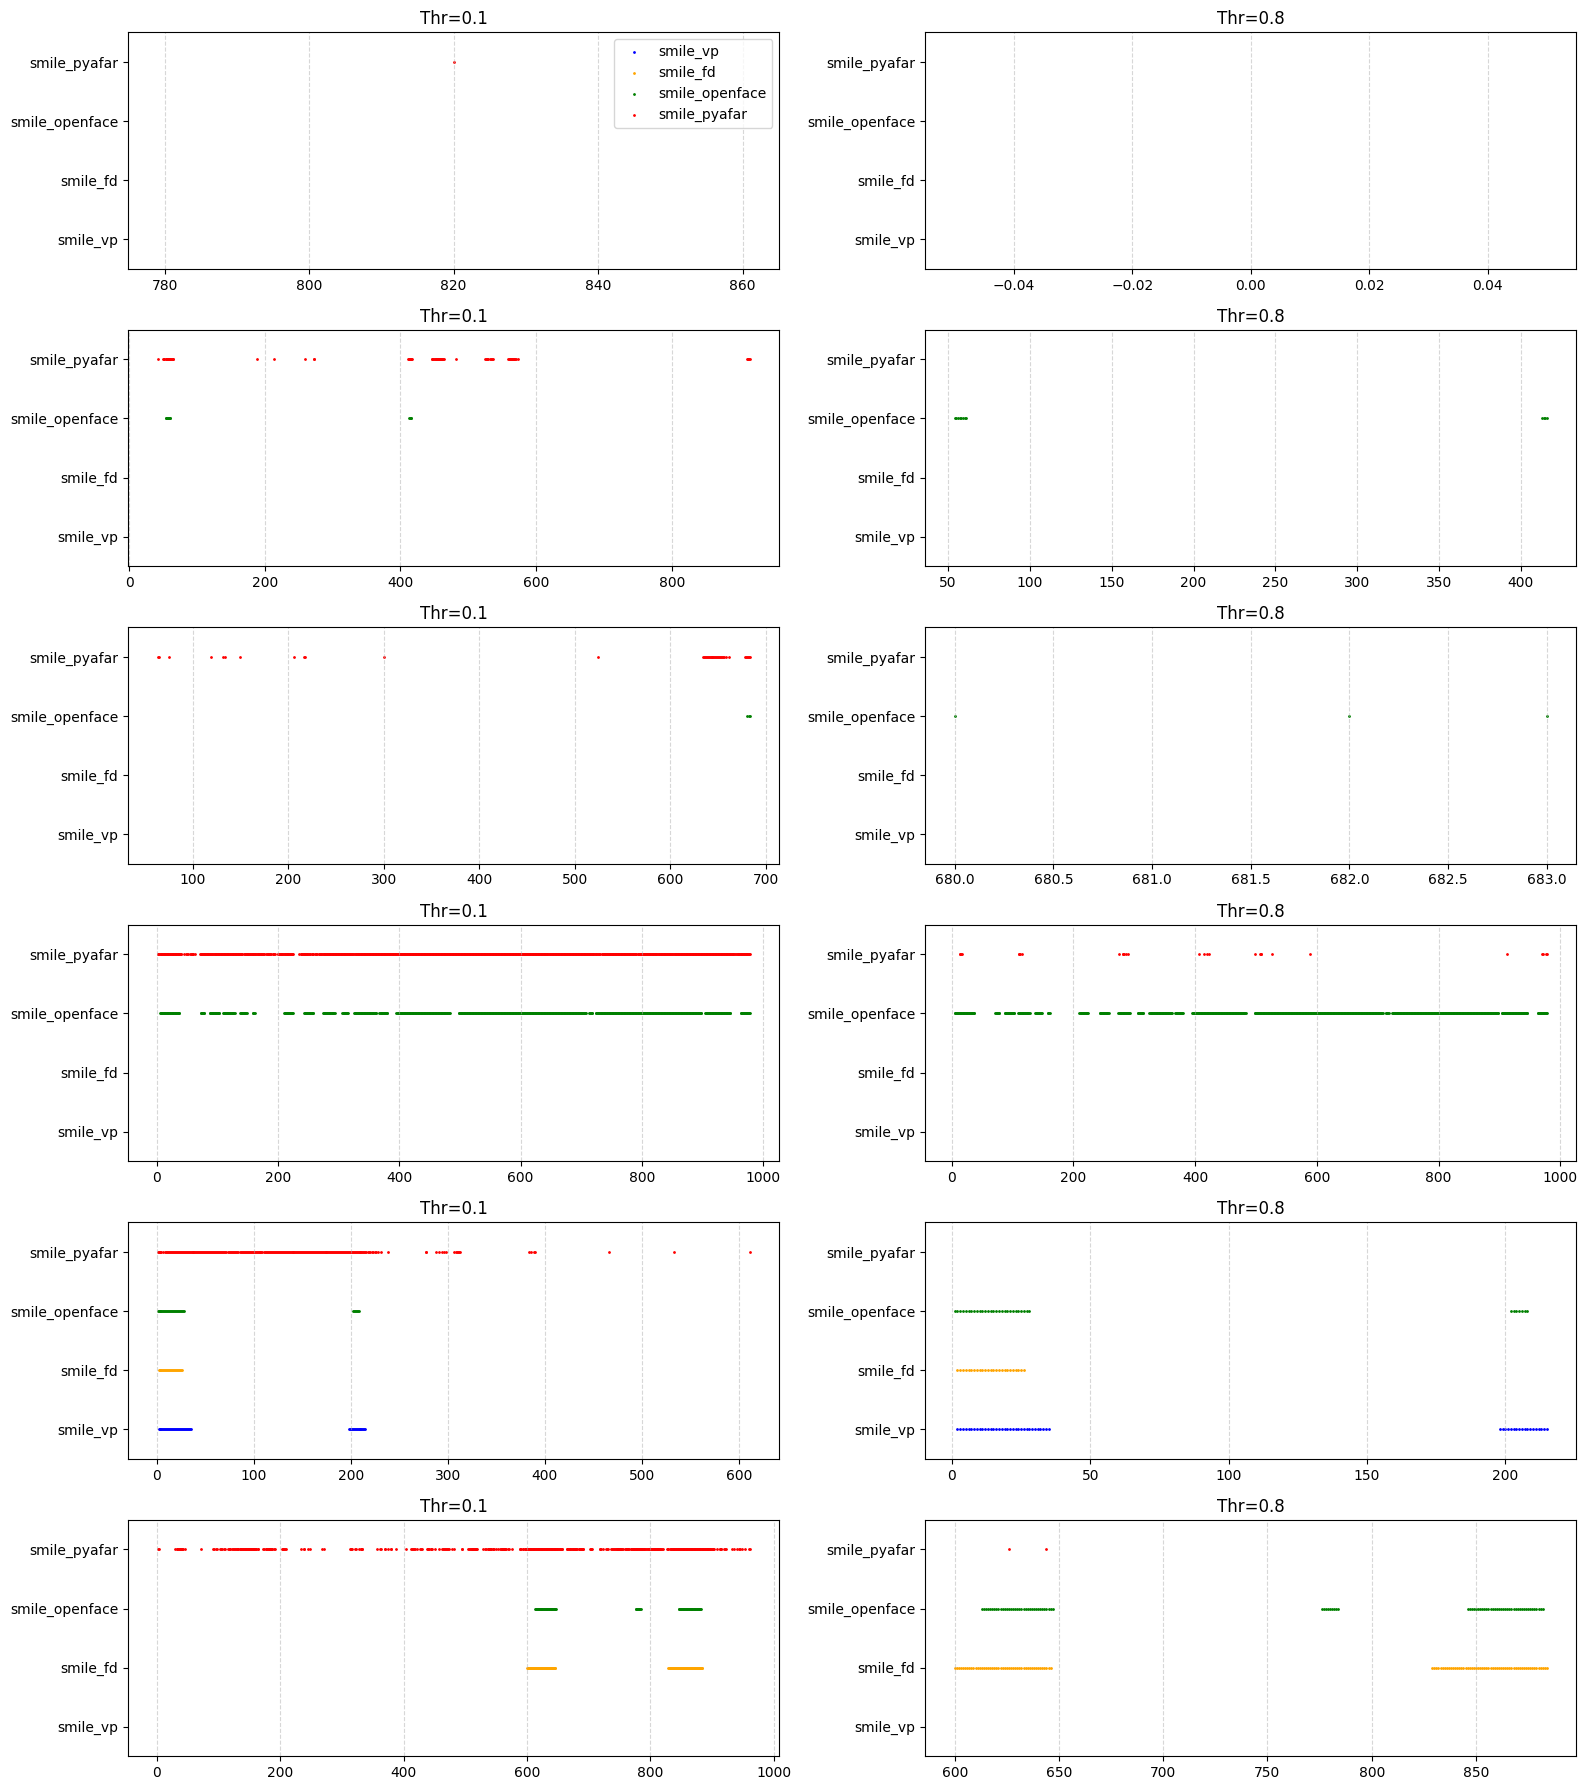

In [5]:
# Participants and clips
participant_ids = df_NT['participant_id'].unique()[1:2]  # first 2 participants
clip_ids = sorted(df_NT['clip'].unique())               # sort clips ascending
thresholds = [0.1, 0.8]

# Measures (both gaze_occ & gaze_dev_occ with FD and VP)
measures = ['smile_vp', 'smile_fd', 'smile_openface', 'smile_pyafar']
measure_display_names = ['annotator 1', 'annotator 2', 'OpenFace', 'PyAFAR']
colors = ['blue', 'orange', 'green', 'red']

# Grid dimensions
n_rows = len(participant_ids) * len(clip_ids)
n_cols = len(thresholds)

plt.figure(figsize=(8 * n_cols, 3 * n_rows))
plot_num = 1

for participant_id in participant_ids:
    for clip_id in clip_ids:  # now ordered ascending
        df_sub = df_NT[(df_NT['participant_id'] == participant_id) &
                        (df_NT['clip'] == clip_id)]
        if df_sub.empty:
            continue

        for threshold in thresholds:
            # Compute gaze_occ and gaze_dev_occ
            df_sub['smile_pyafar'] = (df_sub['smile_pyafar_pre'] >= threshold).astype(int)

            ax = plt.subplot(n_rows, n_cols, plot_num)
            for i, (measure, color) in enumerate(zip(measures, colors)):
                frames = df_sub['frame'][df_sub[measure] == 1]
                values = [i + 1] * len(frames)
                ax.scatter(frames, values, color=color, s=1, label=measure if plot_num == 1 else "")

            ax.set_yticks(range(1, len(measures) + 1))
            ax.set_yticklabels(measure_display_names) 
            ax.set_yticklabels(measures)
            ax.set_ylim(0.5, len(measures) + 0.5)
            ax.set_title(f'Thr={threshold}')
            ax.grid(axis='x', linestyle='--', alpha=0.5)

            if plot_num == 1:
                ax.legend(loc='upper right')

            plot_num += 1

plt.tight_layout()
plt.show()


### Smile: agreement plots for different threshold values

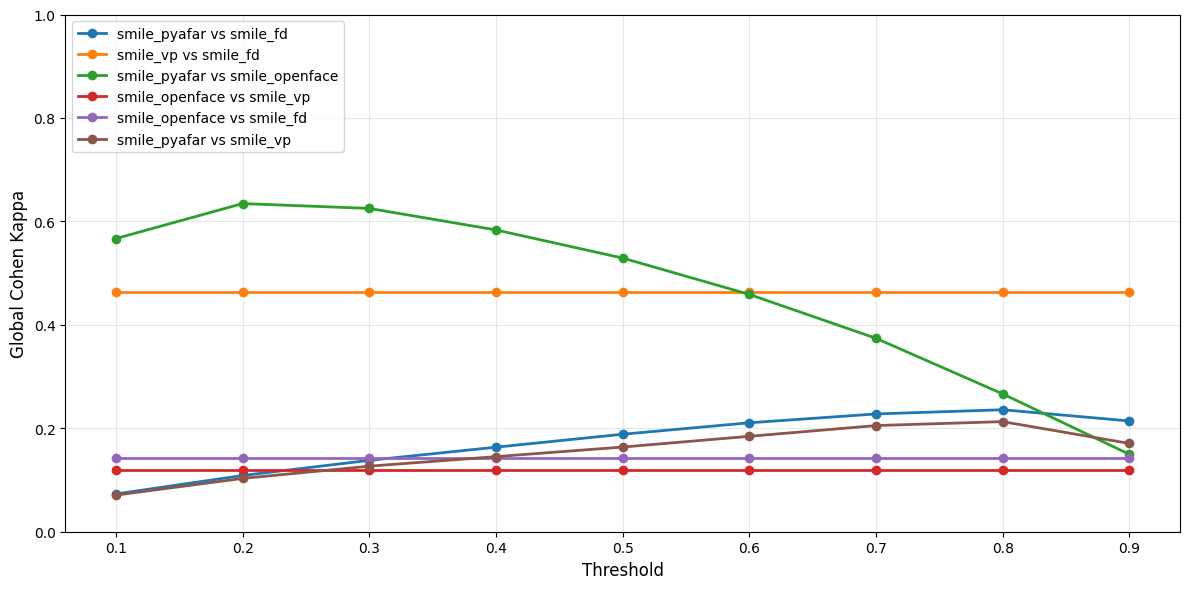

In [6]:
# Define the annotator pairs (you can add more)
annotator_compare = [
    ['smile_pyafar', 'smile_fd'], 
    ['smile_vp', 'smile_fd'], 
    ['smile_pyafar', 'smile_vp'],
    ['smile_openface', 'smile_fd'],  
    ['smile_openface', 'smile_vp'],
    ['smile_pyafar', 'smile_openface'],
    # Add more pairs if needed
]

# Thresholds to test
thresholds = np.arange(0.1, 1.0, 0.1)

# Store results
global_cohen_kappa = []

for thr in thresholds:
    # Compute binary smile_dev_occ for this threshold
    df_NT['smile_pyafar'] = (df_NT['smile_pyafar_pre'] > thr).astype(int)

    for i, (annotator_1, annotator_2) in enumerate(annotator_compare):
        # Filter valid rows
        valid_rows = df_NT[[annotator_1, annotator_2]].dropna()

        # Binarize
        annotator1_binary = (valid_rows[annotator_1] != 0).astype(int)
        annotator2_binary = (valid_rows[annotator_2] != 0).astype(int)

        # Compute Cohen's kappa
        score = cohen_kappa_score(annotator1_binary, annotator2_binary)
        global_cohen_kappa.append([thr, f'{annotator_1} vs {annotator_2}', score])

# Plotting
plt.figure(figsize=(12, 6))
for annotator_pair in set([label for _, label, _ in global_cohen_kappa]):
    x = [thr for thr, label, _ in global_cohen_kappa if label == annotator_pair]
    y = [score for thr, label, score in global_cohen_kappa if label == annotator_pair]
    plt.plot(x, y, marker='o', label=annotator_pair, linewidth=2, markersize=6)

plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Global Cohen Kappa', fontsize=12)
#plt.title('Gaze Agreement vs Threshold for Different Comparisons', fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(thresholds, [f'{t:.1f}' for t in thresholds])
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


### Final plot 

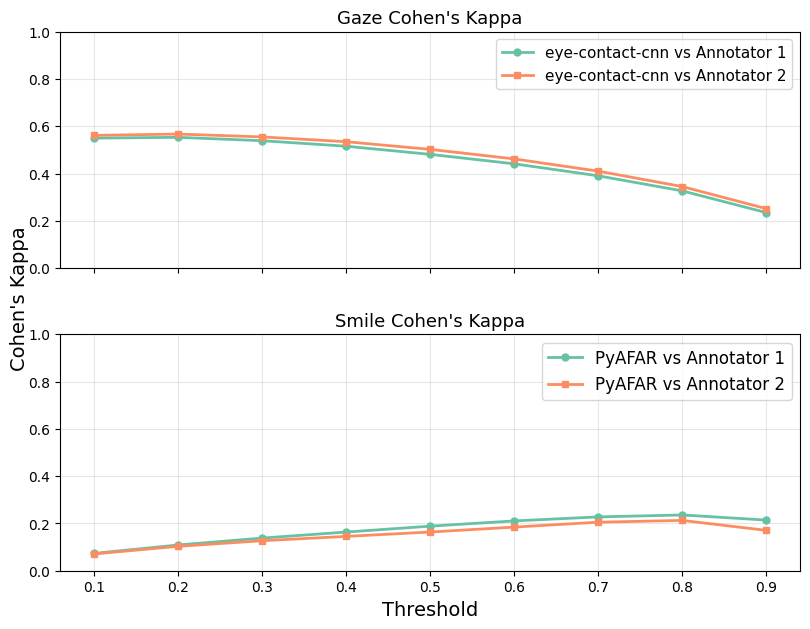

In [7]:

# ----------------------------
# Config
# ----------------------------
# Define annotator pairs for gaze and smile
gaze_pairs = [
    ['gaze_pyafar', 'gaze_fd'],
    ['gaze_pyafar', 'gaze_vp'],
]
smile_pairs = [
    ['smile_pyafar', 'smile_fd'],
    ['smile_pyafar', 'smile_vp'],
]

# Friendly legend labels
gaze_display_names = {
    'gaze_pyafar vs gaze_fd': 'eye-contact-cnn vs Annotator 1',
    'gaze_pyafar vs gaze_vp': 'eye-contact-cnn vs Annotator 2',
}
smile_display_names = {
    'smile_pyafar vs smile_fd': 'PyAFAR vs Annotator 1',
    'smile_pyafar vs smile_vp': 'PyAFAR vs Annotator 2',
}

# Thresholds
thresholds = np.arange(0.1, 1.0, 0.1)

# ----------------------------
# Helpers
# ----------------------------
def pair_label(a1, a2):
    return f"{a1} vs {a2}"

def normalize_name(name):
    """Strip leading 'gaze_' or 'smile_' to unify color mapping across modalities."""
    return name.split('_', 1)[1] if '_' in name else name

def normalize_pair(label):
    """Convert 'mod_a vs mod_b' to 'a vs b' for color-consistent mapping."""
    a, b = label.split(' vs ')
    return f"{normalize_name(a)} vs {normalize_name(b)}"

# Build unified set of normalized pair names across both modalities
all_pairs = [pair_label(*p) for p in gaze_pairs] + [pair_label(*p) for p in smile_pairs]
unique_norm_pairs = sorted({normalize_pair(lbl) for lbl in all_pairs})

# Color + marker assignment (consistent across both subplots)
palette = sns.color_palette("Set2", n_colors=len(unique_norm_pairs))
pair_to_color = {norm: palette[i] for i, norm in enumerate(unique_norm_pairs)}
markers_cycle = ['o', 's', '^', 'D', 'P', 'X', '*', 'v']  # enough variety
pair_to_marker = {norm: markers_cycle[i % len(markers_cycle)] for i, norm in enumerate(unique_norm_pairs)}

# ----------------------------
# Compute results
# ----------------------------
gaze_results = []   # list of (thr, pair_label, score)
for thr in thresholds:
    # binarize model output for this threshold (as per your original rule)
    df_NT['gaze_pyafar'] = 1 - (df_NT['gaze_pyafar_pre'] > thr).astype(int)
    for a1, a2 in gaze_pairs:
        valid_rows = df_NT[[a1, a2]].dropna()
        y1 = (valid_rows[a1] != 0).astype(int)
        y2 = (valid_rows[a2] != 0).astype(int)
        gaze_results.append((thr, pair_label(a1, a2), cohen_kappa_score(y1, y2)))

smile_results = []
for thr in thresholds:
    df_NT['smile_pyafar'] = (df_NT['smile_pyafar_pre'] > thr).astype(int)
    for a1, a2 in smile_pairs:
        valid_rows = df_NT[[a1, a2]].dropna()
        y1 = (valid_rows[a1] != 0).astype(int)
        y2 = (valid_rows[a2] != 0).astype(int)
        smile_results.append((thr, pair_label(a1, a2), cohen_kappa_score(y1, y2)))

# ----------------------------
# Plotting (vertical, compact, legends outside, shared y label)
# ----------------------------
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True, sharey=True)

# --- Gaze subplot ---
ax = axes[0]
for pair in sorted({lbl for _, lbl, _ in gaze_results}):
    xs = [t for t, lbl, _ in gaze_results if lbl == pair]
    ys = [s for t, lbl, s in gaze_results if lbl == pair]
    norm = normalize_pair(pair)
    ax.plot(xs, ys,
            marker=pair_to_marker[norm], linewidth=2, markersize=5,
            label=gaze_display_names.get(pair, pair),
            color=pair_to_color[norm])
ax.set_title("Gaze Cohen's Kappa", fontsize=13)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)
ax.legend(fontsize=11, loc='upper right')#, bbox_to_anchor=(1.02, 0.5))

# --- Smile subplot ---
ax = axes[1]
for pair in sorted({lbl for _, lbl, _ in smile_results}):
    xs = [t for t, lbl, _ in smile_results if lbl == pair]
    ys = [s for t, lbl, s in smile_results if lbl == pair]
    norm = normalize_pair(pair)
    ax.plot(xs, ys,
            marker=pair_to_marker[norm], linewidth=2, markersize=5,
            label=smile_display_names.get(pair, pair),
            color=pair_to_color[norm])
ax.set_title("Smile Cohen's Kappa", fontsize=13)
ax.set_xlabel("Threshold", fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_xticks(thresholds)
ax.set_xticklabels([f"{t:.1f}" for t in thresholds])
ax.set_ylim(0, 1)
ax.legend(fontsize=12, loc='upper right')#, bbox_to_anchor=(1.02, 0.5))

# Single shared y-axis label
fig.text(0.03, 0.5, "Cohen's Kappa", va='center', rotation='vertical', fontsize=14)

# Tight, with room on the right for the legends
plt.subplots_adjust(left=0.08, right=0.82, hspace=0.28)
plt.show()


#### Probability score to binary values based on threshold that achieves highest agreement

In [8]:
df['gaze_pyafar'] = 1 - (df['gaze_pyafar_pre'] >= 0.2).astype(int) 
df['smile_pyafar'] = (df['smile_pyafar_pre'] >= 0.8).astype(int)


In [9]:
df.to_csv(paths.features_2 / "extracted_features.csv", index=False)